Original Graph:
{1: {2: 3, 3: 1}, 2: {1: 3, 3: 3, 4: 1}, 3: {1: 1, 2: 3, 4: 3, 5: 2}, 4: {2: 1, 3: 3, 5: 4}, 5: {3: 2, 4: 4}}

Displaying original graph...


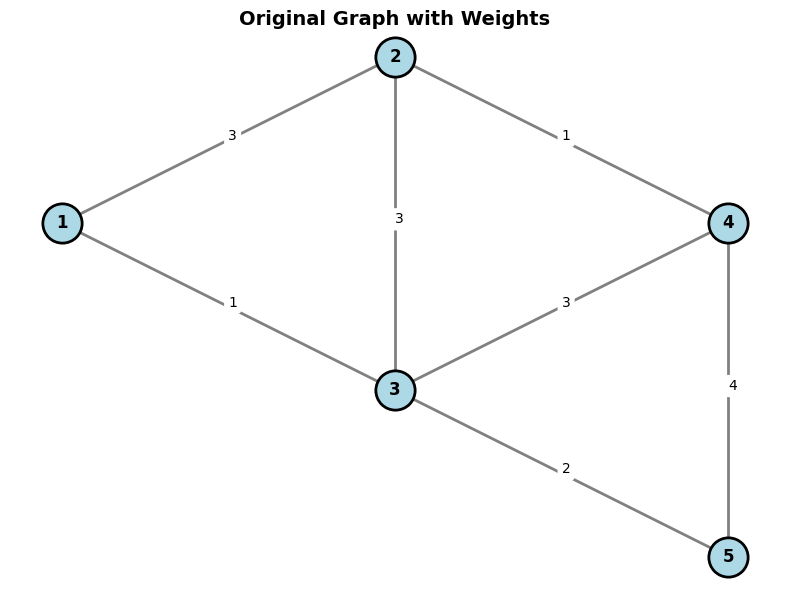


Running Karger's Algorithm with Visualization


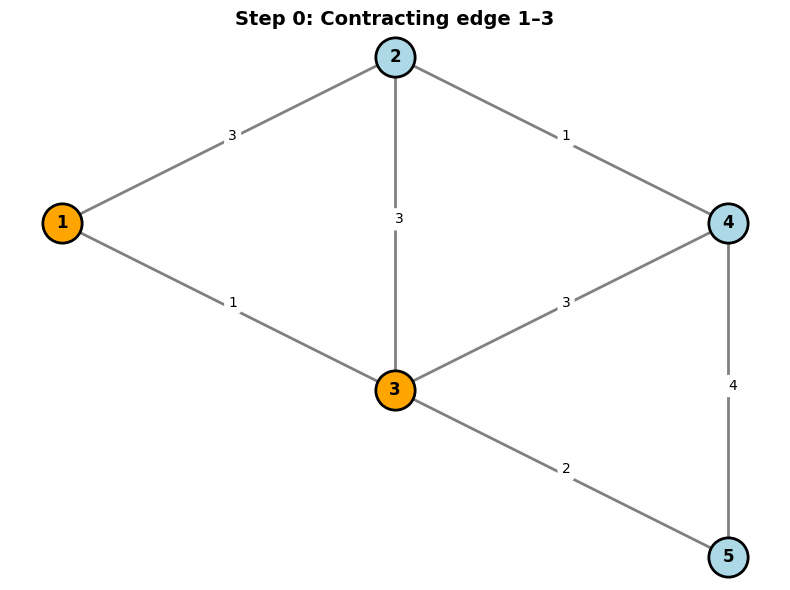

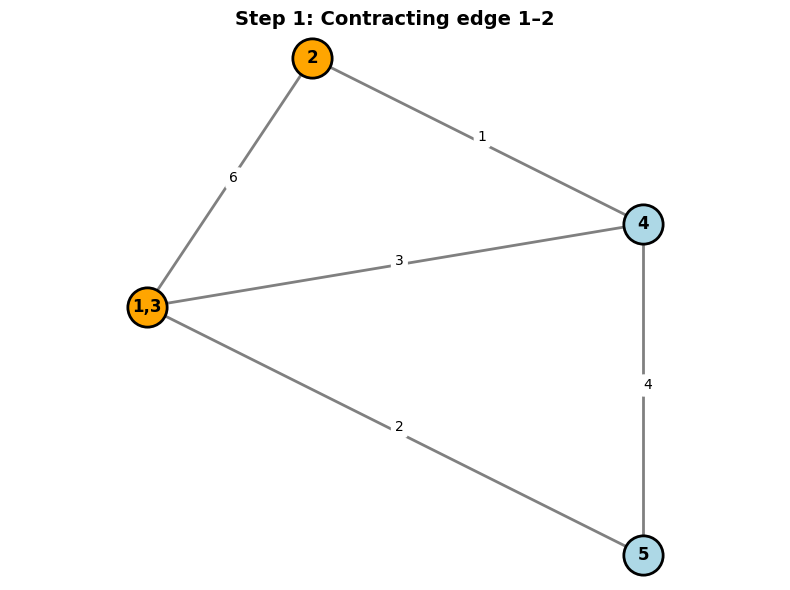

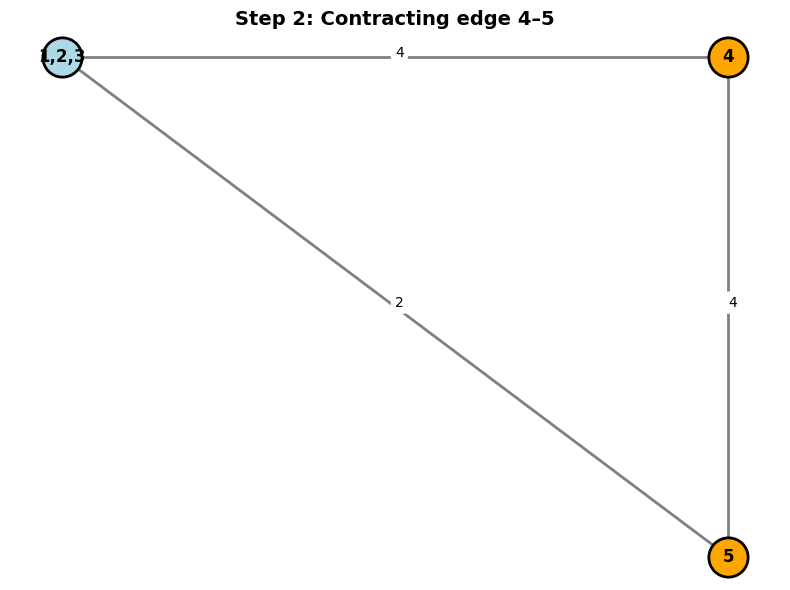

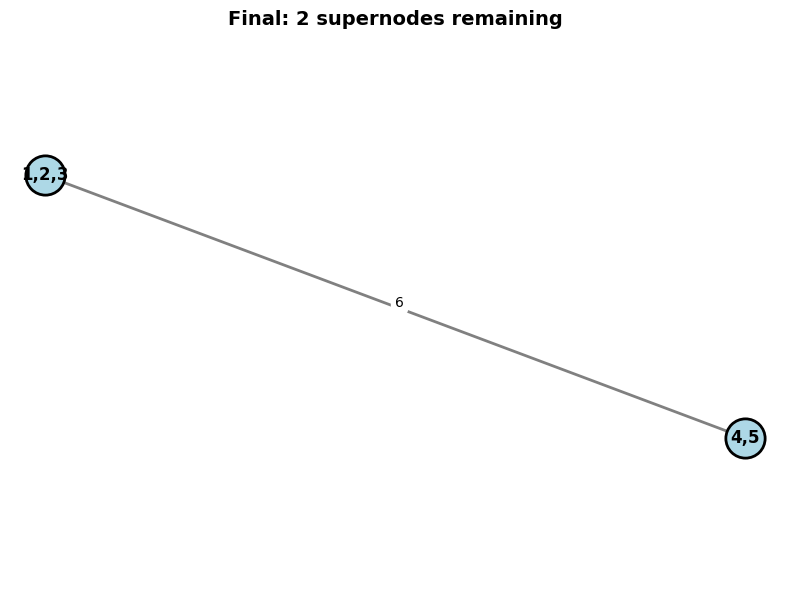


Cut Value: 6
Partition S: [1, 2, 3]
Partition T: [4, 5]


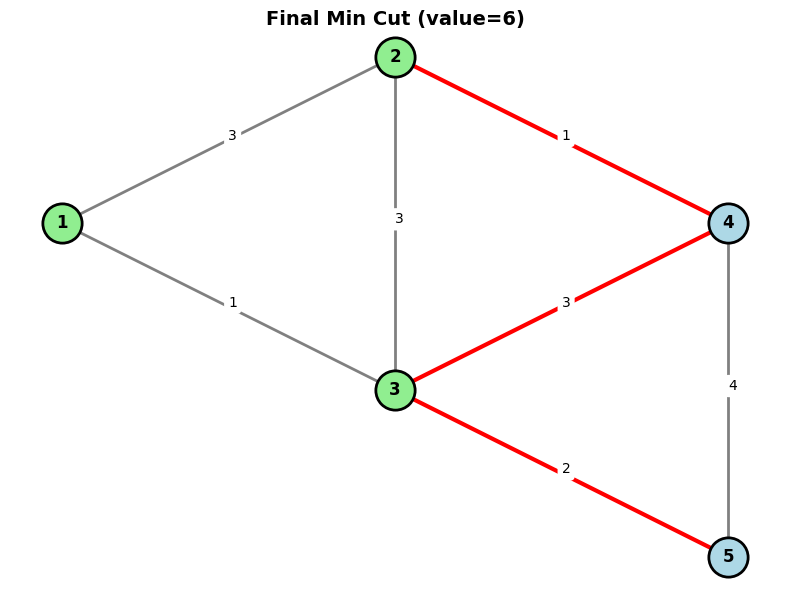

In [90]:
# ==============================================================================
# Karger's Min-Cut Algorithm - Complete Working Code (Corrected)
# ==============================================================================

import random
import matplotlib.pyplot as plt

%matplotlib inline

# -----------------------------
# Build the test graph
# -----------------------------
def build_test_graph_adj():
    G = {}
    def add_edge(u, v, w):
        G.setdefault(u, {})[v] = w
        G.setdefault(v, {})[u] = w

    edges = [
        (1, 2, 3), (1, 3, 1), (2, 3, 3), (2, 4, 1),
        (3, 4, 3), (3, 5, 2), (4, 5, 4),
    ]
    for u, v, w in edges:
        add_edge(u, v, w)
    return G

G = build_test_graph_adj()
print("Original Graph:")
print(G)
print()

# Fixed positions for visualization
fixed_pos = {
    1: (-1.0,  0.5),
    2: ( 0.0,  1.0),
    3: ( 0.0,  0.0),
    4: ( 1.0,  0.5),
    5: ( 1.0, -0.5),
}

# -----------------------------
# Drawing helpers
# -----------------------------
def draw_graph_basic(G, pos, supernode_mapping, title="Graph",
                     node_colors=None, highlight_edges=None):
    """
    Draw graph with proper supernode positioning.
    G: current contracted graph (adjacency dict)
    pos: original node positions
    supernode_mapping: node -> set(original_nodes)
    """
    plt.figure(figsize=(8, 6))

    # Current positions from centroids of original nodes
    current_pos = {}
    for node in G:
        original_nodes = supernode_mapping.get(node, {node})
        xs = [pos[o][0] for o in original_nodes if o in pos]
        ys = [pos[o][1] for o in original_nodes if o in pos]
        if xs and ys:
            current_pos[node] = (sum(xs) / len(xs), sum(ys) / len(ys))

    # Draw edges
    seen = set()
    for u in G:
        if u not in current_pos:
            continue
        for v, w in G[u].items():
            if (v, u) in seen or v not in current_pos:
                continue
            x1, y1 = current_pos[u]
            x2, y2 = current_pos[v]

            color = "gray"
            linewidth = 2
            if highlight_edges and ((u, v) in highlight_edges or (v, u) in highlight_edges):
                color = "red"
                linewidth = 3

            plt.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth, zorder=1)

            # Edge weight label
            mx, my = (x1 + x2) / 2, (y1 + y2) / 2
            plt.text(mx, my, str(w), color="black", fontsize=10,
                     bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='white', edgecolor='none'),
                     zorder=2)
            seen.add((u, v))

    # Draw nodes
    for u in G:
        if u not in current_pos:
            continue
        x, y = current_pos[u]
        c = node_colors.get(u, "lightblue") if node_colors else "lightblue"

        original_nodes = supernode_mapping.get(u, {u})
        label = ",".join(map(str, sorted(original_nodes)))

        plt.scatter([x], [y], s=800, color=c, edgecolors="black",
                    linewidths=2, zorder=3)
        plt.text(x, y, label, ha="center", va="center", fontsize=12,
                 color="black", fontweight="bold", zorder=4)

    plt.title(title, fontsize=14, fontweight="bold")
    plt.axis("equal")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Displaying original graph...")
original_mapping = {i: {i} for i in G.keys()}
draw_graph_basic(G, fixed_pos, original_mapping, title="Original Graph with Weights")

# -----------------------------
# Karger's algorithm with visualization
# -----------------------------
def karger_min_cut_with_visualization(G_input, pos, show_steps=True):
    """
    Karger's algorithm with step-by-step visualization.
    G_input is not modified.
    """
    # Deep copy
    G = {u: dict(neighs) for u, neighs in G_input.items()}
    supernodes = {u: {u} for u in G}

    step = 0
    while len(G) > 2:
        # Collect all undirected edges once
        edges = []
        weights = []
        for u in G:
            for v, w in G[u].items():
                if u < v:
                    edges.append((u, v))
                    weights.append(w)

        if not edges:
            break

        # Pick random edge weighted by weight
        u, v = random.choices(edges, weights=weights, k=1)[0]

        # If one endpoint got contracted away in a previous iteration,
        # skip this edge safely
        if u not in G or v not in G:
            continue
        if u not in supernodes or v not in supernodes:
            continue

        if show_steps:
            colors = {node: "lightblue" for node in G}
            colors[u] = colors[v] = "orange"
            draw_graph_basic(G, pos, supernodes,
                             title=f"Step {step}: Contracting edge {u}–{v}",
                             node_colors=colors)

        # Contract: merge v into u
        supernodes.setdefault(u, set()).update(supernodes.get(v, set()))
        if v in supernodes:
            del supernodes[v]

        # Rewire edges from v to u
        for nbr, w in list(G[v].items()):
            if nbr == u:
                continue
            # Neighbor might already have been removed
            if nbr not in G:
                continue
            # Remove edge nbr–v if it still exists
            if v in G[nbr]:
                del G[nbr][v]
            # Add or accumulate edge nbr–u
            G[u][nbr] = G[u].get(nbr, 0) + w
            G[nbr][u] = G[nbr].get(u, 0) + w

        # Remove v from graph
        del G[v]
        # Remove self-loop on u if present
        G[u].pop(u, None)

        step += 1

    if show_steps:
        draw_graph_basic(G, pos, supernodes,
                         title=f"Final: {len(G)} supernodes remaining")

    # Extract result
    nodes = list(G.keys())
    if len(nodes) < 2:
        return 0, (set(), set())

    a, b = nodes[0], nodes[1]
    cut_value = G[a].get(b, 0)
    return cut_value, (supernodes[a], supernodes[b])

# -----------------------------
# Run with visualization
# -----------------------------
print("\n" + "="*70)
print("Running Karger's Algorithm with Visualization")
print("="*70)

cut_val, (S, T) = karger_min_cut_with_visualization(G, fixed_pos, show_steps=True)

print("\n" + "="*70)
print(f"Cut Value: {cut_val}")
print(f"Partition S: {sorted(S)}")
print(f"Partition T: {sorted(T)}")
print("="*70)

# -----------------------------
# Final cut drawing on original graph
# -----------------------------
def draw_final_cut(G_input, partition, pos, title="Min Cut"):
    S, T = map(set, partition)

    # Find cut edges
    cut_edges = set()
    seen = set()
    for u in G_input:
        for v in G_input[u]:
            if (v, u) in seen:
                continue
            if (u in S and v in T) or (u in T and v in S):
                cut_edges.add((u, v))
            seen.add((u, v))

    node_colors = {u: ("lightgreen" if u in S else "lightblue")
                   for u in G_input}
    mapping = {u: {u} for u in G_input}
    draw_graph_basic(G_input, pos, mapping, title=title,
                     node_colors=node_colors, highlight_edges=cut_edges)

draw_final_cut(G, (S, T), fixed_pos, title=f"Final Min Cut (value={cut_val})")

# -----------------------------
# Non-visual version for repeats
# -----------------------------
def karger_no_viz(G_input):
    G = {u: dict(neighs) for u, neighs in G_input.items()}
    supernodes = {u: {u} for u in G}

    while len(G) > 2:
        edges = [(u, v) for u in G for v in G[u] if u < v]
        if not edges:
            break
        weights = [G[u][v] for u, v in edges]

        u, v = random.choices(edges, weights=weights, k=1)[0]

        if u not in G or v not in G:
            continue
        if u not in supernodes or v not in supernodes:
            continue

        supernodes.setdefault(u, set()).update(supernodes.get(v, set()))
        if v in supernodes:
            del supernodes[v]

        for nbr, w in list(G[v].items()):
            if nbr == u:
                continue
            if nbr not in G:
                continue
            if v in G[nbr]:
                del G[nbr][v]
            G[u][nbr] = G[u].get(nbr, 0) + w
            G[nbr][u] = G[nbr].get(u, 0) + w

        del G[v]
        G[u].pop(u, None)

    nodes = list(G.keys())
    if len(nodes) < 2:
        return 0, (set(), set())
    a, b = nodes[0], nodes[1]
    return G[a].get(b, 0), (supernodes[a], supernodes[b])
